In [1]:
# imports the necessary requirements
from langchain_openai import ChatOpenAI
import pm4py
import duckdb
import os
from crewai import Agent, Task, Crew
# Importing crewAI tools
from crewai_tools import (
    DirectoryReadTool,
    FileReadTool,
    SerperDevTool,
    WebsiteSearchTool
)
#import pickle

In [ ]:
# sets the API key (always needed!)
os.environ["OPENAI_API_KEY"] = open("api_key.txt", "r").read()

# sets the address of the APIs and the required model

# DeepInfra Qwen2-7B-Instruct
#llm = ChatOpenAI(model="Qwen/Qwen2-7B-Instruct", base_url="https://api.deepinfra.com/v1/openai/")

# OpenAI's GPT-4o Mini model 
llm = ChatOpenAI(model="gpt-4o-mini", base_url="https://api.openai.com/v1")

# OpenAI's GPT-3.5-turbo
#llm = ChatOpenAI(model="gpt-3.5-turbo", base_url="https://api.openai.com/v1")

In [4]:
# reads the event log in-memory using pm4py
log = pm4py.read_xes("log02_06.xes")


# computes the DFG abstraction
dfg_abstraction = pm4py.llm.abstract_dfg(log)

parsing log, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

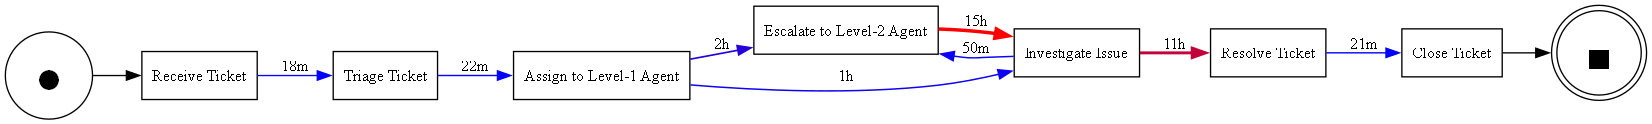

In [5]:

from pm4py.visualization.dfg import visualizer as dfg_visualizer

performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(log)
pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)

In [6]:
print(dfg_abstraction)

If I have a process with flow:

Triage Ticket -> Assign to Level-1 Agent ( frequency = 5  performance = 1320.000 )
Resolve Ticket -> Close Ticket ( frequency = 5  performance = 1260.000 )
Receive Ticket -> Triage Ticket ( frequency = 5  performance = 1080.000 )
Investigate Issue -> Resolve Ticket ( frequency = 5  performance = 42120.000 )
Assign to Level-1 Agent -> Investigate Issue ( frequency = 4  performance = 4125.000 )
Escalate to Level-2 Agent -> Investigate Issue ( frequency = 2  performance = 54900.000 )
Investigate Issue -> Escalate to Level-2 Agent ( frequency = 1  performance = 3000.000 )
Assign to Level-1 Agent -> Escalate to Level-2 Agent ( frequency = 1  performance = 9000.000 )



